# Udacity - Machine Learning Engineer Nanodegree Program

## Final Capstone Project

### Stock Price Prediction Using Machine Learning
In this project, I will use the power of Machine Learning to predict the Stock closing price using some of models namely LSTM and GRU to predict the Amazon's (FAANG stock) closing price.

### Common Modules for the project

In [96]:
import quandl
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.layers import BatchNormalization

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM,GRU
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from math import sqrt

### Stock data downloader

Pull the data from Quandl first and add the 50days, 100days, 200days into [50, 100, 200]
In the Quandl database, Open, High, Low, Close, Volume are all adjusted.

In [2]:
## Stock downloader..
def download_stock_data(stock):
    columns = ['date','adj_open','adj_low','adj_high','adj_volume','adj_close']
    quandl.ApiConfig.api_key = 'RcePNacJwS3WiJR-kww_'
    
    data = quandl.get_table('WIKI/PRICES', ticker = stock, qopts = { 'columns': columns })
     # Renaming all the columns so that we can use the old version code
    data.rename(columns={'adj_open': 'Open', 'adj_high': 'High', 'adj_low': 'Low', 'adj_volume': 'Volume'}, inplace=True)
    data.set_index('date', inplace=True)
    return data

In [3]:
df = download_stock_data('AMZN')
df.to_csv('amazon.csv',index = False)
df.head()

,Open,Low,High,Volume,adj_close
date,,,,,
1997-05-16,1.865000,1.708333,1.979167,14700000.0,1.729167
1997-05-19,1.708333,1.625000,1.770833,6106800.0,1.708333
1997-05-20,1.729167,1.635833,1.750000,5467200.0,1.635833
1997-05-21,1.604167,1.375000,1.645833,18853200.0,1.427500
1997-05-22,1.437500,1.312500,1.448333,11776800.0,1.395833


### Normalize the Stock data and add more technical features
Now, Add more add the PCT 50days, 100days, 200days into [50, 100, 200]

In [4]:
## Define a normalizer for stock data
def process_and_normalize(df,ma=[50,100,200]):
    # Percentage change
    df['Pct'] = df['adj_close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['adj_close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
     # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler()
    numerical = ['Open', 'Low','High' ,'Volume','adj_close','Pct','50ma','100ma','200ma']
    df[numerical] = scaler.fit_transform(df[numerical])
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['adj_close']
    df.drop(labels=['adj_close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [5]:
df = process_and_normalize(df)
df.head()

,Open,Low,High,Volume,Pct,50ma,100ma,200ma,adj_close
date,,,,,,,,,
1998-03-04,0.000056,0.000204,0.000054,0.061247,0.457843,0.000000,0.000000,0.000000,0.000094
1998-03-05,0.000043,0.000270,0.000258,0.106602,0.453940,0.000024,0.000019,0.000020,0.000176
1998-03-06,0.000244,0.000401,0.000197,0.047441,0.457471,0.000047,0.000038,0.000041,0.000267
1998-03-09,0.000308,0.000559,0.000649,0.213569,0.566548,0.000079,0.000061,0.000065,0.000621
1998-03-10,0.000755,0.000881,0.000778,0.229964,0.410197,0.000111,0.000083,0.000089,0.000600


In [8]:
plt.rcParams['figure.figsize'] = (18, 12)
## Visualize the stock data.
def plot_stock_data(df):
    plt.subplot(211)
    plt.plot(df['adj_close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()
    
## visualize the data correlation
def plot_stock_corr(df):
    corr = df.corr()
    ax = sns.heatmap(corr, cmap="YlGnBu")
    plt.show()

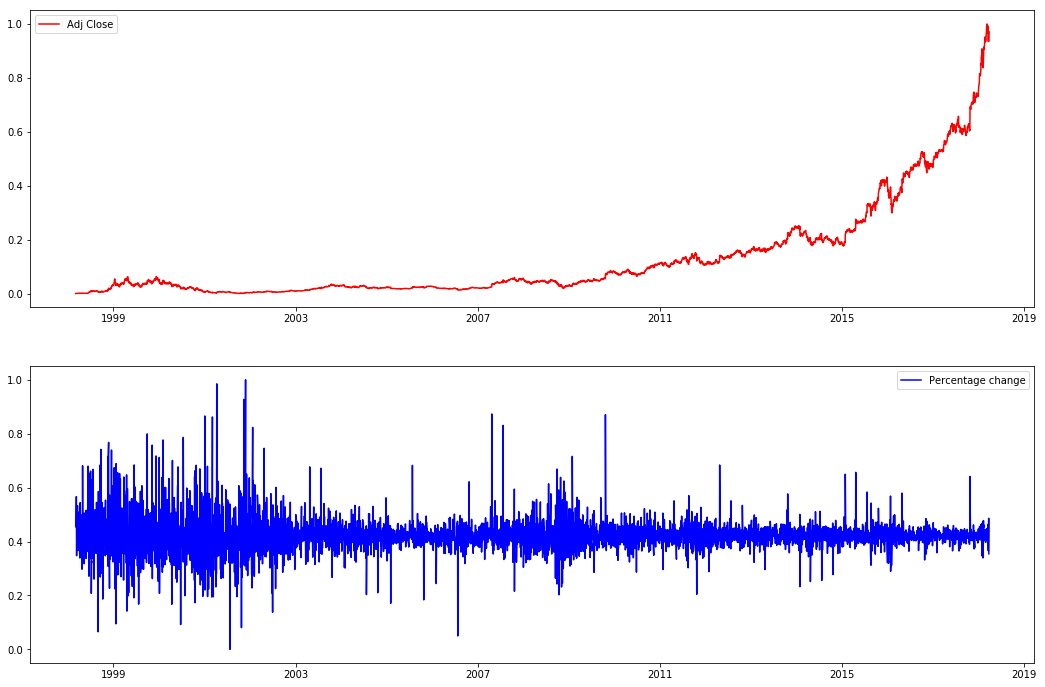

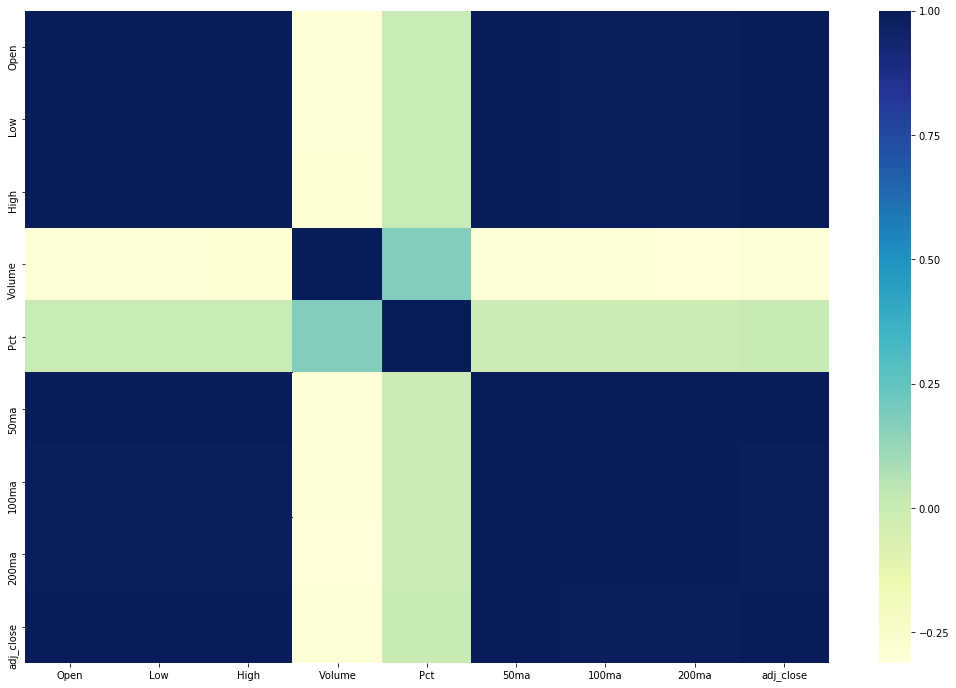

In [9]:
plot_stock_data(df)
plot_stock_corr(df)

In [10]:
## Define a function to eval the mean for few columns.
def show_min_max(data):
    print(data.head())

    print("\n")
    print("Open   - mean :", np.mean(data['Open']),  " Std: ", np.std(data['Open']),  " Max: ", np.max(data['Open']),  " Min: ", np.min(data['Open']))
    print("Low    - mean :", np.mean(data['Low']), " Std: ", np.std(data['Low']), " Max: ", np.max(data['Low']), " Min: ", np.min(data['Low']))
    print("High   - mean :", np.mean(data['High'])," Std: ", np.std(data['High'])," Max: ", np.max(data['High'])," Min: ", np.min(data['High']))
    print("Close  - mean :", np.mean(data['adj_close']), "   Std: ", np.std(data['adj_close']), " Max: ", np.max(data['adj_close']), " Min: ", np.min(data['adj_close']))
    print("Volume - mean :", np.mean(data['Volume'])," Std: ", np.std(data['Volume'])," Max: ", np.max(data['Volume'])," Min: ", np.min(data['Volume']))

In [11]:
show_min_max(df)

                Open       Low      High    Volume       Pct      50ma  \
date                                                                     
1998-03-04  0.000056  0.000204  0.000054  0.061247  0.457843  0.000000   
1998-03-05  0.000043  0.000270  0.000258  0.106602  0.453940  0.000024   
1998-03-06  0.000244  0.000401  0.000197  0.047441  0.457471  0.000047   
1998-03-09  0.000308  0.000559  0.000649  0.213569  0.566548  0.000079   
1998-03-10  0.000755  0.000881  0.000778  0.229964  0.410197  0.000111   

               100ma     200ma  adj_close  
date                                       
1998-03-04  0.000000  0.000000   0.000094  
1998-03-05  0.000019  0.000020   0.000176  
1998-03-06  0.000038  0.000041   0.000267  
1998-03-09  0.000061  0.000065   0.000621  
1998-03-10  0.000083  0.000089   0.000600  


('Open   - mean :', 0.12634242367338944, ' Std: ', 0.1767287238240672, ' Max: ', 1.0, ' Min: ', 0.0)
('Low    - mean :', 0.1269081379555572, ' Std: ', 0.17777602995612357,

In [12]:
## Save to CSV for future use
df.to_csv('amazon_normalized.csv',index = False)

## Section - 1 : Data processing, Design Bench Mark Model, Training, Prediction & Accuracy

### Step : 1 
   **Data Processing, choosing less set of feartures**

In [48]:
## Define a function to process the data
def process_stock_data(data):
    # Define fewer columns of features
    item = []
    open = []
    close = []
    volume = []

    # Loop through the data
    i_counter = 0
    for i in range(len(data) - 1):
        item.append(i_counter)
        open.append(data['Open'][i])
        close.append(data['adj_close'][i])
        volume.append(data['Volume'][i])
        i_counter += 1

    stocks = pd.DataFrame()

    # Add factors to data frame
    stocks['Item'] = item
    stocks['Open'] = open
    stocks['Close'] = pd.to_numeric(close)
    stocks['Volume'] = pd.to_numeric(volume)

    return stocks

In [49]:
regression_df = process_stock_data(df)
regression_df.head()

,Item,Open,Close,Volume
0,0,0.000056,0.000094,0.061247
1,1,0.000043,0.000176,0.106602
2,2,0.000244,0.000267,0.047441
3,3,0.000308,0.000621,0.213569
4,4,0.000755,0.000600,0.229964


In [50]:
## Define visualize function
def price(x):
    return '$%1.2f' % x

def plot_regression_data(stocks, title='Amazon Trading', y_label='Price', x_label='Trading Days'):
    fig, ax = plt.subplots()
    ax.plot(stocks['Item'], stocks['Close'], 'red')

    ax.format_ydata = price
    ax.set_title(title)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

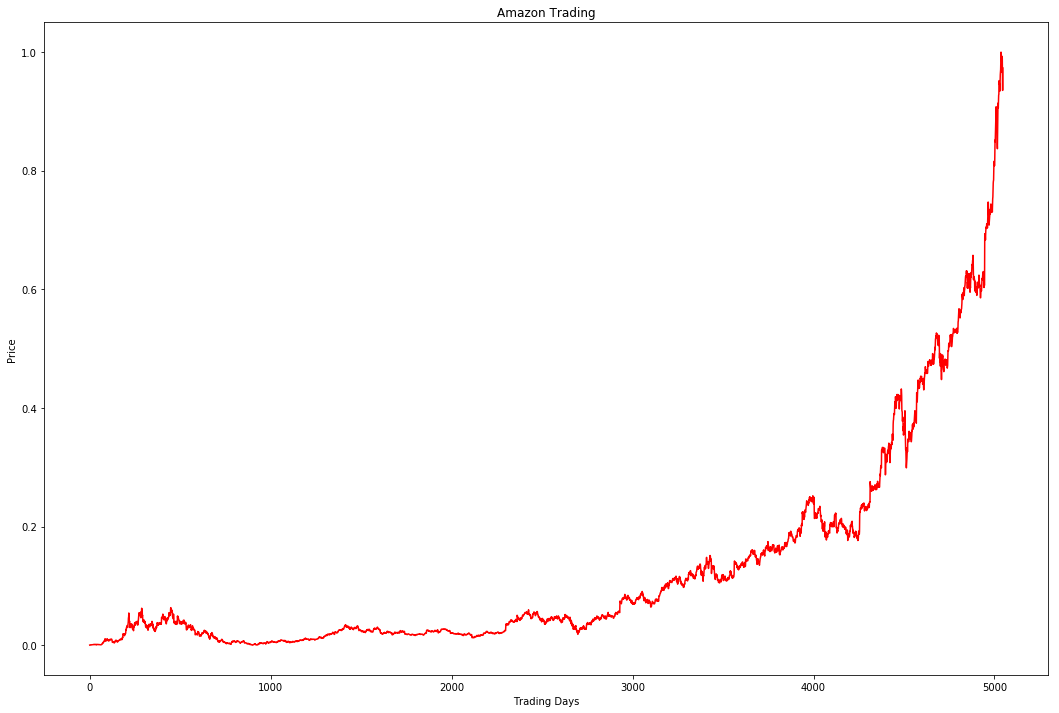

In [51]:
plot_regression_data(regression_df)

### Step : 2
   **Split the data**

In [52]:
## Define the method to split the data into Test and Train for model.


def scale_range(x, input_range, target_range):
    range = [np.amin(x), np.amax(x)]
    x_std = (x - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    x_scaled = x_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return x_scaled, range

def split_train_test_linear_regression(data):
    # Create numpy arrays for features and targets
    feature = []
    label = []

    # Convert dataframe columns to numpy arrays for scikit learn
    for index, row in data.iterrows():
        feature.append([(row['Item'])])
        label.append([(row['Close'])])

    # Regularize the feature and target arrays and store min/max of input data for rescaling later
    feature_bounds = [min(feature), max(feature)]
    feature_bounds = [feature_bounds[0][0], feature_bounds[1][0]]
    label_bounds = [min(label), max(label)]
    label_bounds = [label_bounds[0][0], label_bounds[1][0]]

    feature_scaled, feature_range = scale_range(np.array(feature), input_range=feature_bounds, target_range=[-1.0, 1.0])
    label_scaled, label_range = scale_range(np.array(label), input_range=label_bounds, target_range=[-1.0, 1.0])

    # Define Test/Train Split 80/20
    split = .315
    split = int(math.floor(len(data['Item']) * split))

    # Set up training and test sets
    X_train = feature_scaled[:-split]
    X_test = feature_scaled[-split:]

    y_train = label_scaled[:-split]
    y_test = label_scaled[-split:]

    return X_train, X_test, y_train, y_test, label_range

In [53]:
X_train, X_test, y_train, y_test, label_range= split_train_test_linear_regression(regression_df)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

('x_train', (3458, 1))
('y_train', (3458, 1))
('x_test', (1589, 1))
('y_test', (1589, 1))


### Step : 3
   **Design the Benchmark Regression Model **

In [54]:
## Define a function for Linear Regression.
def build_linear_regression_model(X, y):
    # defining linear regression model
    linear_mdl = linear_model.LinearRegression()  
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))
    # fit the data in the model
    linear_mdl.fit(X, y)  

    return linear_mdl

### Step : 4
   **Compile the model and fit the data **

In [55]:
regression_model = build_linear_regression_model(X_train,y_train)

### Step : 5
   **Use the model for data prediction **

In [56]:
## Define the function for stock prediction.
def predict_stock_prices(model, x, label_range):
    x = np.reshape(x, (x.shape[0], 1))
    predicted_price = model.predict(x)
    predictions_rescaled, re_range = scale_range(predicted_price, input_range=[-1.0, 1.0], target_range=label_range)

    return predictions_rescaled.flatten()

In [57]:
predictions = predict_stock_prices(regression_model,X_test, label_range)

### Step : 6
   **Use prediction data to visualize **

In [58]:
def plot_regression_prediction(actual, prediction, title='Amazon Trading vs Prediction', y_label='Price', x_label='Trading Days'):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, 'red', label='Adjusted Close')
    plt.plot(prediction, 'blue', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()

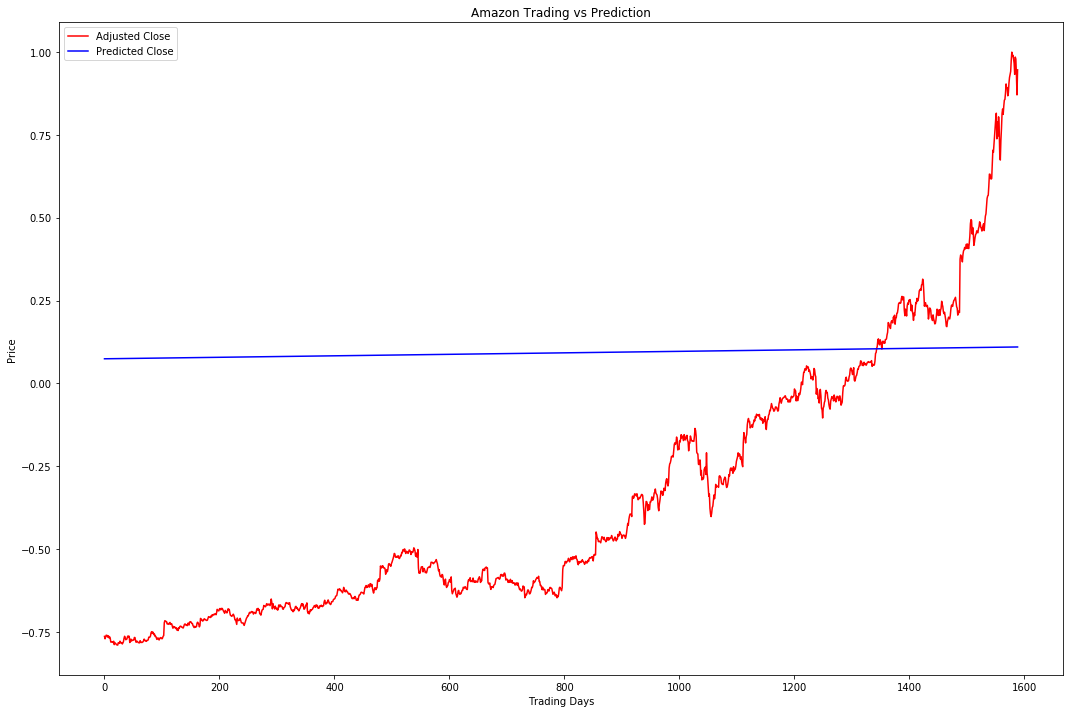

In [59]:
plot_regression_prediction(y_test,predictions)

### Step : 7
   **Calculate the model error **

In [60]:
def calculate_model_error_accuracy(X_train, y_train, y_test,predictions):
    trainScore = mean_squared_error(X_train, y_train)
    print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))

    testScore = mean_squared_error(predictions, y_test)
    print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))


In [61]:
## Calculate the errors
calculate_model_error_accuracy(X_train, y_train, y_test,predictions)

Train Score: 0.5021 MSE (0.7086 RMSE)
Test Score: 0.34418044 MSE (0.58666893 RMSE)


## Section - 2 : Data Split, Design LSTM Model, Training, Prediction & Accuracy

### Step : 1
**Define the split function for LSTM model**

In [62]:
## Define the Data split function based on a sequence length.

def split_train_test_lstm(stock, seq_len):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days

    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * result.shape[0]))

    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [63]:
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 32, 1]
lstm_df = df
X_train, y_train, X_test, y_test = split_train_test_lstm(lstm_df, seq_len)

Amount of features = 9
Amount of training data = 4522.5
Amount of testing data = 502.5


/Users/i850472/Documents/local/anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### Step : 2
**Design a basic LSTM model**

In [90]:
def build_basic_model(shape, neurons):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    
    model.add(Dense(neurons[2],activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model

### Step : 3
**Build and compile basic LSTM model**

In [91]:
lstm_basic_model = build_basic_model(shape,neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 22, 256)           272384    
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 469,633
Trainable params: 469,633
Non-trainable params: 0
_________________________________________________________________


### Step : 4
**Train basic LSTM model**

In [92]:
epochs = 1
lstm_basic_model.fit(X_train, y_train,epochs=epochs,validation_split=0.2)

Train on 3216 samples, validate on 804 samples
Epoch 1/1
3216/3216 [==============================] - 16s 5ms/step - loss: 5.5280e-04 - acc: 3.1095e-04 - val_loss: 5.6814e-05 - val_acc: 0.0000e+00


### Step : 5
**Prediction using basic LSTM model**

In [93]:
predictions = lstm_basic_model.predict(X_test)

In [94]:
## Define a visualize function to plot the lstm prediction..
def plot_lstm_stock_prediction(actual, prediction, title='Amazon Prediction', y_label='Price', x_label='Trading Days'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, 'red', label='Adjusted Close')
    plt.plot(prediction, 'blue', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()

### Step : 6
**Plot the predictions using basic LSTM model**

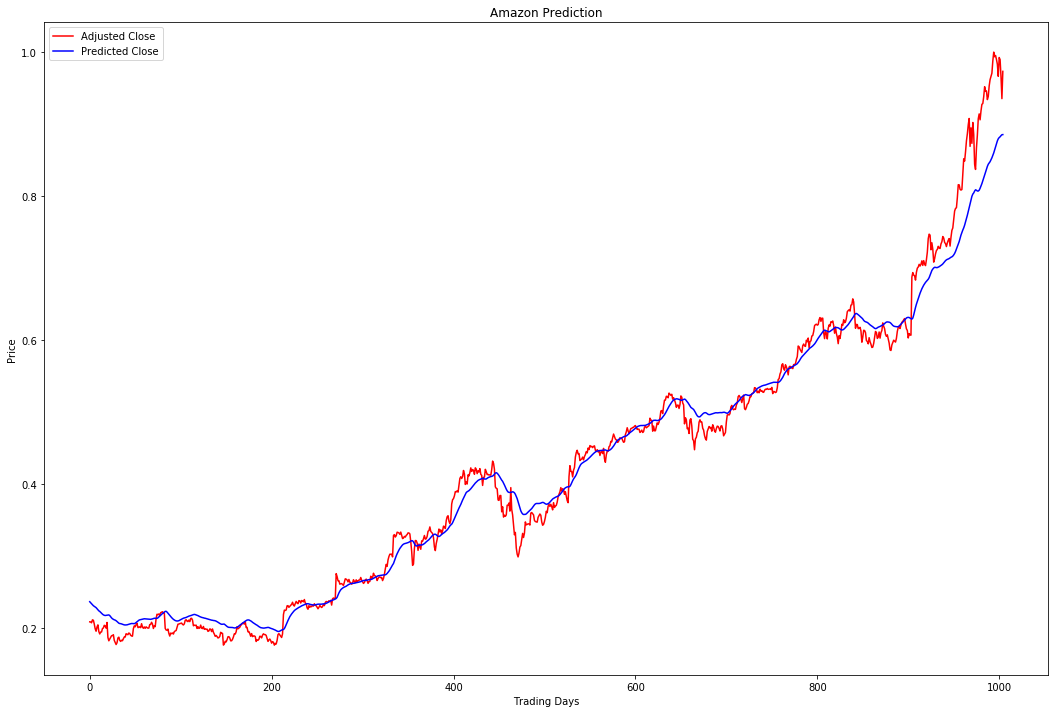

In [95]:
plot_lstm_stock_prediction(y_test,predictions)

### Step : 7
**Error/accuracy score of basic LSTM model**

In [70]:
## Define a function to eval the errors.
def model_lstm_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [71]:
model_lstm_score(lstm_basic_model,X_train, y_train, X_test, y_test)

Train Score: 0.00004412 MSE (0.00664239 RMSE)
Test Score: 0.04161486 MSE (0.20399721 RMSE)


(4.4121310226945573e-05, 0.041614863135161537)

### Optimised LSTM Model
 **Step : 1 - Build the enhanced Model**

In [84]:
def build_optimized_lstm_model(shape, neurons, dropout):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))

    model.add(Dropout(dropout))
    
    model.add(Dense(neurons[2],activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

#### Step : 2 - Compile the model with optimized params

In [97]:
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 128, 1]
dropout = 0.2
epochs = 20
batch_size = 100
validation_split = 0.2
optimized_lstm_model = build_optimized_lstm_model(shape, neurons, dropout)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 22, 256)           272384    
_________________________________________________________________
dropout_22 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 469,633
Trainable params: 469,633
Non-trainable params: 0
_________________________________________________________________


### Step : 3
**Train using Optimized LSTM model**

In [98]:
optimized_lstm_model.fit(
                        X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=validation_split,
                        verbose=1)

Train on 3216 samples, validate on 804 samples
Epoch 1/20
3216/3216 [==============================] - 9s 3ms/step - loss: 0.0013 - acc: 3.1095e-04 - val_loss: 2.7197e-04 - val_acc: 0.0000e+00
Epoch 2/20
3216/3216 [==============================] - 6s 2ms/step - loss: 4.5194e-05 - acc: 3.1095e-04 - val_loss: 6.6487e-05 - val_acc: 0.0000e+00
Epoch 3/20
3216/3216 [==============================] - 6s 2ms/step - loss: 2.9853e-05 - acc: 3.1095e-04 - val_loss: 5.8071e-05 - val_acc: 0.0000e+00
Epoch 4/20
3216/3216 [==============================] - 7s 2ms/step - loss: 2.4454e-05 - acc: 3.1095e-04 - val_loss: 7.2818e-05 - val_acc: 0.0000e+00
Epoch 5/20
3216/3216 [==============================] - 6s 2ms/step - loss: 2.1489e-05 - acc: 3.1095e-04 - val_loss: 5.5729e-05 - val_acc: 0.0000e+00
Epoch 6/20
3216/3216 [==============================] - 6s 2ms/step - loss: 1.9508e-05 - acc: 3.1095e-04 - val_loss: 4.5878e-05 - val_acc: 0.0000e+00
Epoch 7/20
3216/3216 [==============================] - 6

### Step : 4
**Prediction using Optimized LSTM model**

In [99]:
opt_predictions = optimized_lstm_model.predict(X_test)

### Step : 5
**Plot the predictions using Optimized LSTM model**

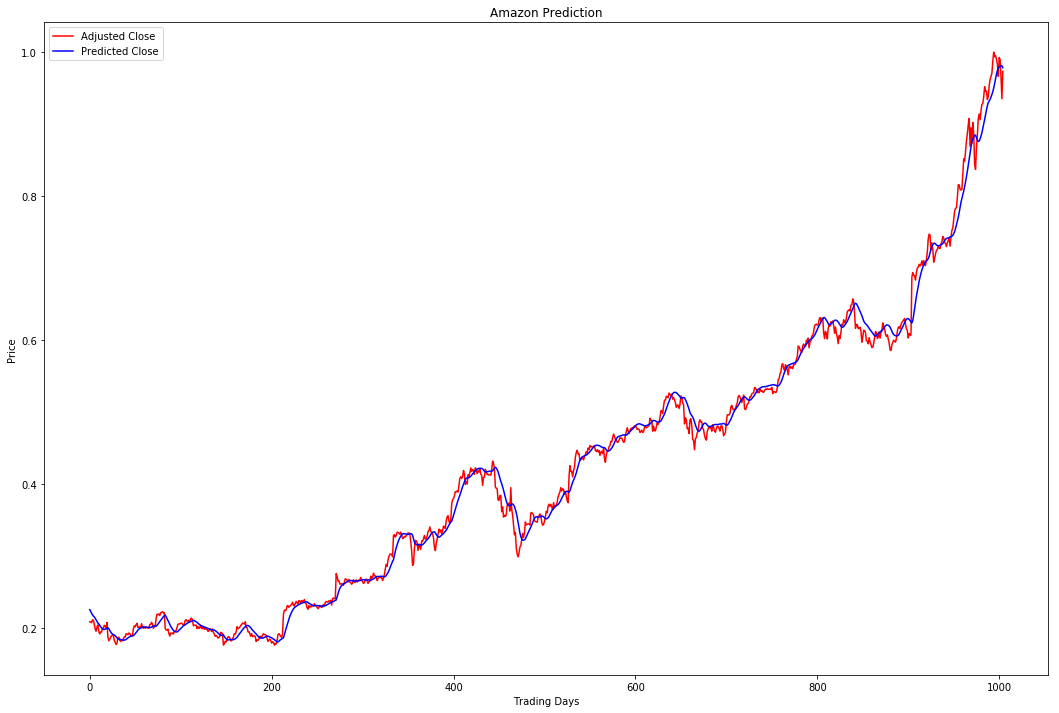

In [100]:
plot_lstm_stock_prediction(y_test,opt_predictions)

### Step : 6
**Error/accuracy score of Optimized LSTM model**

In [101]:
model_lstm_score(optimized_lstm_model,X_train, y_train, X_test, y_test)

Train Score: 0.00000976 MSE (0.00312377 RMSE)
Test Score: 0.00020909 MSE (0.01445986 RMSE)


(9.7579438092613251e-06, 0.00020908747865721139)

## Section - 3 : Data Split, Design GRU Model, Training, Prediction & Accuracy

### Step : 1
**Define the split function for GRU model**

In [27]:
##Define the splity funtion for GRU..
def split_train_test_gru(stock, seq_len, split):
    amount_of_features = len(stock.columns)
    data = stock.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
#     scaler = RobustScaler()
#     data = scaler.fit_transform(data)
    
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 
    
    result = np.array(result)
    
    row = round(split * result.shape[0])
    train = result[:int(row), :]
    X_train = train[:, :, :-1] 
    y_train = train[:, :, -1][:, -1]
    
    X_test = result[int(row):, :, :-1]
    y_test = result[int(row):, :, -1][:, -1]
    
    return [X_train, y_train, X_test, y_test]

In [28]:
gru_df = df
no_of_features = len(gru_df.columns)
seq_len= 21
split = 0.8
layers = [seq_len, 10]
epochs = 1

In [29]:
X_train, y_train, X_test, y_test = split_train_test_gru(gru_df, seq_len, split)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4021, 22, 8), (4021,), (1005, 22, 8), (1005,))

### Step : 2
**Define the basic GRU model**

In [30]:
## Build the basic model..
def build_basic_gru_model(layers):
        model = Sequential()
        
        model.add(GRU(2048, input_shape=(layers[0]+1, layers[1]-1), return_sequences=True))
        model.add(GRU(1024, return_sequences=True))
        model.add(GRU(512, return_sequences=False))       
        
        model.add(Dense(1, activation='linear'))
        
        model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
        return model

### Step : 3
**Compile the basic GRU model**

In [31]:
gru_basic_model = build_basic_gru_model([seq_len, no_of_features])

### Step : 4
**Train basic GRU model**

In [32]:
gru_basic_model.fit(X_train,
                    y_train,
                    epochs=epochs, 
                    validation_split=0.2)

Train on 3216 samples, validate on 805 samples
Epoch 1/1
3216/3216 [==============================] - 281s 87ms/step - loss: 0.0178 - acc: 3.1095e-04 - val_loss: 6.2196e-05 - val_acc: 0.0000e+00


### Step : 5
**Prediction using Basic GRU model**

In [33]:
predictions = gru_basic_model.predict(X_test)

### Step : 6
**Plot the predictions using Basic GRU model**

In [37]:
plt.rcParams['figure.figsize'] = (18, 12)
## Define a visualize function to plot the gru prediction..
def plot_gru_stock_prediction(actual, prediction, title='Amazon GRU Prediction', y_label='Price', x_label='Trading Days'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, 'red', label='Adjusted Close')
    plt.plot(prediction, 'blue', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()

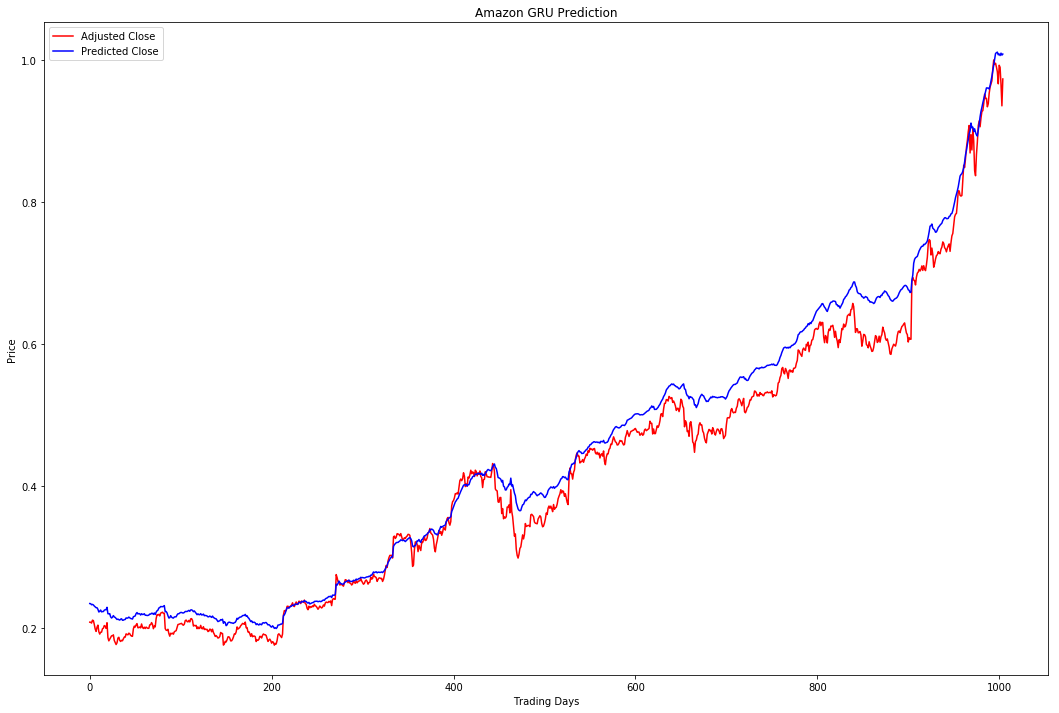

In [38]:
plot_gru_stock_prediction(y_test,predictions)

### Step : 7
**Error/accuracy score of Basic GRU model**

In [46]:
## Define a function to eval the errors.
def model_gru_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [102]:
model_gru_score(gru_basic_model, X_train, y_train, X_test, y_test)

Train Score: 0.00002767 MSE (0.00525995 RMSE)
Test Score: 0.00147107 MSE (0.03835451 RMSE)


(2.7667022326605806e-05, 0.0014710684635894215)

### Optimised GRU Model
 **Step : 1 - Build the enhanced Model**

In [39]:
def build_optimized_gru_model(layers, d):
        model = Sequential()
        
        model.add(GRU(2048, input_shape=(layers[0]+1, layers[1]-1), return_sequences=True))
        model.add(Dropout(d))
        model.add(GRU(1024, return_sequences=True))
        model.add(Dropout(d))
        model.add(GRU(512, return_sequences=False))       
        model.add(Dropout(d))
        model.add(Dense(1, activation='linear'))
        
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

### Step : 2
**Compile the enhanced GRU model**

In [40]:
gru_df = df
no_of_features = len(gru_df.columns)
seq_len= 21
split = 0.8
layers = [seq_len, 10]
epochs = 1
batch_size = 100
gru_opt_model = build_optimized_gru_model([seq_len, no_of_features],0.2)

### Step : 3
**Train the enhanced GRU model**

In [41]:
gru_opt_model.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs, 
                validation_split=0.2)

Train on 3216 samples, validate on 805 samples
Epoch 1/5
3216/3216 [==============================] - 168s 52ms/step - loss: 0.0490 - acc: 3.1095e-04 - val_loss: 1.1916e-04 - val_acc: 0.0000e+00
Epoch 2/5
3216/3216 [==============================] - 178s 55ms/step - loss: 1.5294e-04 - acc: 3.1095e-04 - val_loss: 7.4595e-05 - val_acc: 0.0000e+00
Epoch 3/5
3216/3216 [==============================] - 163s 51ms/step - loss: 5.5174e-05 - acc: 3.1095e-04 - val_loss: 5.5704e-05 - val_acc: 0.0000e+00
Epoch 4/5
3216/3216 [==============================] - 169s 53ms/step - loss: 4.4680e-05 - acc: 3.1095e-04 - val_loss: 5.0198e-05 - val_acc: 0.0000e+00
Epoch 5/5
3216/3216 [==============================] - 165s 51ms/step - loss: 3.7376e-05 - acc: 3.1095e-04 - val_loss: 5.0234e-05 - val_acc: 0.0000e+00


### Step : 4
**Prediction using Optimized GRU model**

In [43]:
opt_predictions = gru_opt_model.predict(X_test)

### Step : 5
**Plot the predictions using Optimized GRU model**

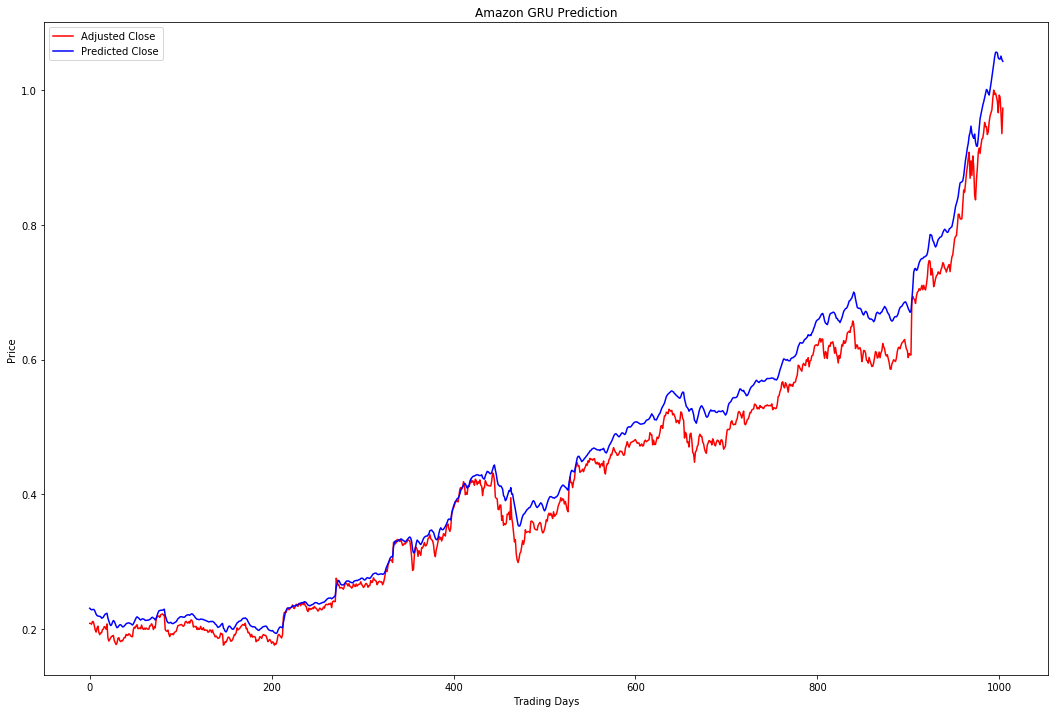

In [44]:
plot_gru_stock_prediction(y_test,opt_predictions)

### Step : 6
**Error/accuracy score of Optimized GRU model**

In [47]:
model_gru_score(gru_opt_model, X_train, y_train, X_test, y_test)

Train Score: 0.00001411 MSE (0.00375587 RMSE)
Test Score: 0.00107527 MSE (0.03279123 RMSE)


(1.4106579102015763e-05, 0.0010752650523391455)